## Basic Wavelet Decomposition Theory

The wavelet decomposition is going to give us series of wavelet coefficients at each scale. The heart of Wavelet analysis is MultiResolution Analysis (MRA), which is the process of synthesizing a discrete signal by starting with a very low-resolution signal and progressively adding layers of detail onto it to create higher resolution signals. A discrete Wavelet transform of a signal *decomposes* it into 2 elements: a detail signal and an average signal. The average signal consists of lower-frequency average values of the signal at a particular scale, around which the detail signal fluctuates; in turn, the detail signal consists of higher-frequency fluctuations about these average values. At the first level of decomposition, we decompose the signal $f$ into these 2 signals and using MRA, we can re-express the signal as:

$$
f = A^1 + D^1
$$

where $A^1$ is the average signal, and $D^1$ is the detail signal. Each successive level of the wavelet decomposition consists of performing a 1-level wavelet decomposition of the previous average signal; therefore, the second level, for example, gives us:

$$
f = A^2 + D^2 + D^1
$$

where $A^2$ is the result of convolving the first average, $A^1$, with the scaling signals $V_i^2$ and $D^2$ is the result of convolving the first average with the wavelets $W_i^2$. Here we have decomposed $f$ into an average signal at an even lower frequency than $A^1$, along with the initial detail signal $D^1$ and the high-frequency fluctuations about $A^2$ which produce $A^1$. Therefore, when we sum $A^2$ and $D^2$ we get $A^1$, which is a slightly higher-resolution average of $f$, and when we add $D^2$, this produces the original signal $f$. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Wavmat import Wavmat 
from idwtra import idwtra
from scipy import signal

from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import pearsonr, norm

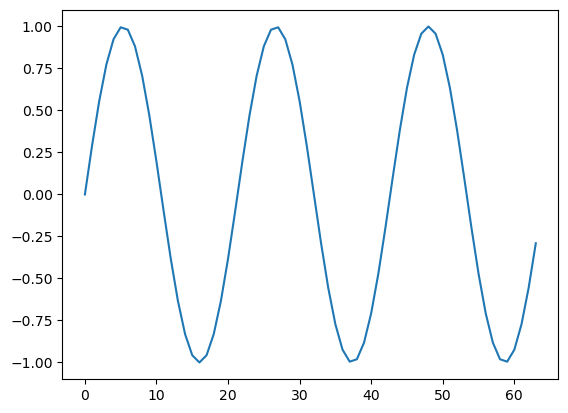

In [2]:
# simple visual: 64-point sine wave
cycles = 3
resolution = 64 

length = np.pi * 2 * cycles
signal = np.sin(np.arange(0, length, length / resolution))

plt.plot(signal)

In [3]:
# decompose signal using Haar

# arrays should be nx1
f = np.transpose(np.matrix(signal))

#use default Haar wavelet
W = Wavmat(64, None, 2) 

#WT of data by 'hfilt' @ 2 levels of detail
wd = W * f

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


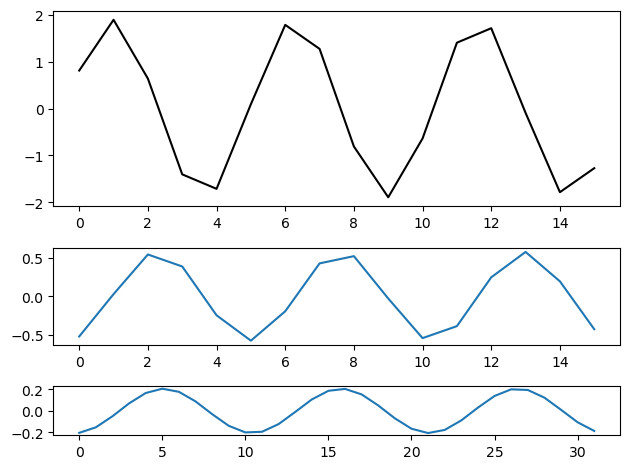

In [4]:
f, (a0, a1, a2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [4, 2, 1]})

a0.plot(wd[0:16], 'k')
a1.plot(wd[16:32])
a2.plot(wd[32:64])

f.tight_layout()

From the above plot we see a 2-level decomposition of a simple 64-point signal using a Haar wavelet. Note that the average signal (in black) is a low-frequency version of the original, consisting of averages of the original signal at a 4-point width (i.e., the average of every 4 points of the original signal). Also note that the first detail signal consists of smaller-scale detail components; these, when added to $A^2$, will produce $A^1$, a slightly-higher-resolution average of the original signal with a sampling frequency of every 2 points, giving it a length of 32 points. Then, the 32-point $D^2$ signal at the bottom, when added to $A^1$, will produce the original signal.

Note that $A^1$ and $D^2$ are the same length, 16, which corresponds to a quarter of the original bandwidth, and $D^2$ is 32 points, consisting of half the bandwidth. We cannot sum these signals together since they are of different lengths. To perform the MRA (inverse Wavelet decomposition), we must first convolve $A^2$ with the scaling signals $V_1^2 ... V_{16}^2$, which are given by the first 16 rows of the $64 \times 64$ matrix $W$. We next convolve $D^2$ with level-2 wavelet signals $W_1^2 ... W_{16}^2$, and $D^1$ with level-1 wavelet signals $W_1^1 ... W_{32}^1$. This results in a set of 3 signals, all length 64, which can be summed together to create the original signal.

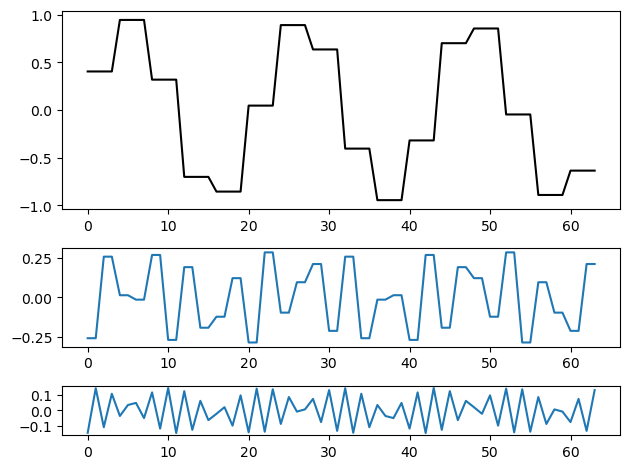

In [41]:
V2 = W[0:16, ]
A2 = wd[0:16]

W2 = W[16:32, ]
D2 = wd[16:32]

W1 = W[32:64, ]
D1 = wd[32:64]

avg1 = np.array(A2.T*V2).flatten()
det2 = np.array(D2.T*W2).flatten()
det1 = np.array(D1.T*W1).flatten()

# plot signals
f, (a0, a1, a2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [4, 2, 1]})

a0.plot(avg1, 'k')
a1.plot(det2)
a2.plot(det1)

f.tight_layout()

Notice how the average signal $A^2$ resembles the original signal, just at a much-reduced resolution. Each flat 'step' in the plot of $A^2$ corresponds to a 4-point average of $f$. If we had performed a 3-level decomposition, it would be an 8-point average, with a 4-level decomposition it would be a 16-point average, and so on. At each level of the decomposition the average signal becomes more coarse. 

Also note how $D^2$ consists of much smaller-magnitude values, between 0.2 and -0.2, and how it fluctuates. This is because it represents the difference or degrees of fluctuation around the average signal between the $A^1$ and $A^2$. In other words, it represents fluctuations in the signal about the mean at the 2-point frequency scale. Importantly, notice how $D^2$ also consists of flat 2-point-wide steps. 

Finally, $D^1$ consists of even smaller-magnitude fluctuations, each with width 1.

Text(0.5, 1.0, '$A^2 + D^2 + D^1$')

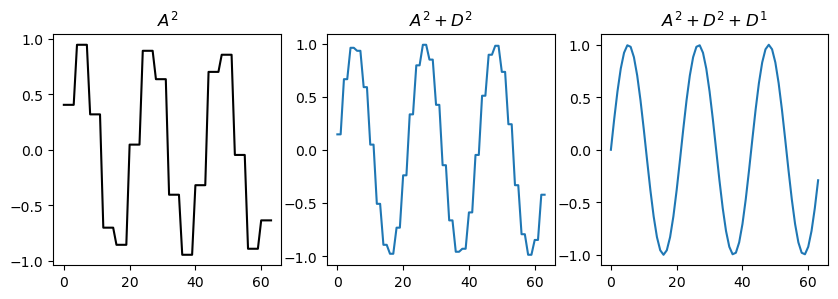

In [49]:
# sum all 3 subsignals together to create original signal
f = avg1 + det2 + det1

fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(avg1, 'k')
ax1.set_title('$A^2$')

ax2.plot(avg1 + det2)
ax2.set_title('$A^2 + D^2$')

ax3.plot(f)
ax3.set_title('$A^2 + D^2 + D^1$')

Below is a visualization of the Wavelet Matrix $W$, constructed from the basis set of elementary signals used to perform the level-2 Haar wavelet decomposition. This consists of the following signals:

Level-2 scaling signals $V_1^2 ... V_{16}^2$:
 
$$
\begin{aligned}
V_1^2 &= \left[\frac{1}{2}, \frac{1}{2}, \frac{1}{2}, \frac{1}{2}, 0, 0, 0, 0 ... 0 \right] \\
V_2^2 &= \left[0, 0, 0, 0, \frac{1}{2}, \frac{1}{2}, \frac{1}{2}, \frac{1}{2}, ... 0 \right] \\
&\cdots \\
V_{16}^2 &= \left[0, 0, 0, 0 ... \frac{1}{2}, \frac{1}{2} \right]
\end{aligned}
$$

Level-2 wavelet signals $W_1^2 ... W_{16}^2$:

$$
\begin{aligned}
W_1^2 &= \left[\frac{1}{2}, \frac{1}{2}, -\frac{1}{2}, -\frac{1}{2} ... 0 \right] \\
W_2^2 &= \left[0, 0, 0, 0, \frac{1}{2}, \frac{1}{2}, -\frac{1}{2}, -\frac{1}{2}, ... 0 \right] \\
&\cdots \\
W_{16}^2 &= \left[0, 0, 0, 0 ... -\frac{1}{2}, -\frac{1}{2} \right]
\end{aligned}
$$

Level-1 wavelet signals $W_1^2 ... W_{32}^2$:

$$
\begin{aligned}
W_1^2 &= \left[\frac{1}{\sqrt{2}}, -\frac{1}{\sqrt{2}}, 0, 0 ... 0 \right] \\
W_2^2 &= \left[0, 0, \frac{1}{\sqrt{2}}, -\frac{1}{\sqrt{2}} ... 0 \right] \\
&\cdots \\
W_{16}^2 &= \left[0, 0, 0, 0 ... \frac{1}{\sqrt{2}}, -\frac{1}{\sqrt{2}} \right]
\end{aligned}
$$

Some things to note:
- $V_i^2$ and $W_i^2$ each have 4 non-zero values since they correspond to the 4-point average and difference
- each subsignal $V_i^j$ and $W_i^j$ is orthogonal; notice that no non-zero values overlap
- the wavelet subsignals (corresponding to the difference signals $D^2$ and $D^1$ have alternating positive and negative values in order to get the degree of fluctuation around the mean for each 4-point and 2-point average, respectively
- the scaling subsignal $V_i^2$ by contrast has all positive values since it returns a 4-point average

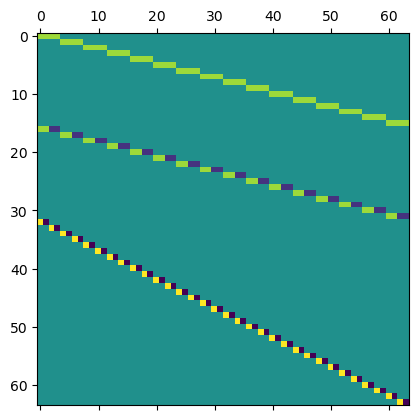

In [60]:
plt.matshow(W)

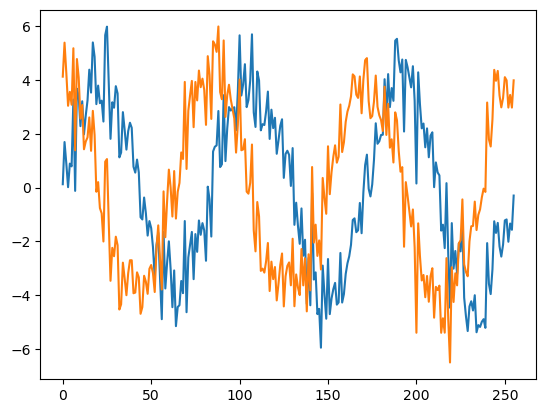

In [29]:
# correlation test

np.random.seed(999)

cycles = 3
resolution = 256 

length = np.pi * 2 * cycles
sin = 4*np.sin(np.arange(0, length, length / resolution))
cos = 4*np.cos(np.arange(0, length, length / resolution))

np.corrcoef(sin, cos)  # these are essentially uncorrelated

# generate some high-frequency noise
noise = np.random.standard_normal((1,resolution)).flatten()
sin_n = sin + noise
cos_n = cos + noise

plt.plot(sin_n)
plt.plot(cos_n)

In [30]:

print(np.corrcoef(sin, cos))      # original signals are almost completely uncorrelated
print(np.corrcoef(sin_n, cos_n))  # noisy signals are slightly correlated

[[1.00000000e+00 2.66374234e-18]
 [2.66374234e-18 1.00000000e+00]]
[[1.         0.11742587]
 [0.11742587 1.        ]]


In [31]:
# decompose signals using Haar

# arrays should be nx1
s = np.transpose(np.matrix(sin_n))
c = np.transpose(np.matrix(cos_n))


#use default Haar wavelet
Wt = Wavmat(256, None, 5) 

#WT of data by 'hfilt' @ 5 levels of detail
wd_s = Wt * s
wd_c = Wt * c

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [32]:
dyadic = [8, 16, 32, 64, 128, 256]

s_decomps = {}
for i in range(len(dyadic)-1):
    s_decomps[f's_l{i+1}'] = np.squeeze(np.array(wd_s[dyadic[i]:dyadic[i+1]]))

c_decomps = {}
for i in range(len(dyadic)-1):
    c_decomps[f'c_l{i+1}'] = np.squeeze(np.array(wd_c[dyadic[i]:dyadic[i+1]]))
    
Slist = list(s_decomps.keys())
Clist = list(c_decomps.keys())

In [33]:
corrs = []

for i in range(len(Slist)):
    corrs.append(np.corrcoef(s_decomps[Slist[i]], c_decomps[Clist[i]])[0,1])

corrs

[0.07819578220103458,
 0.02394379826420161,
 0.4156492899678046,
 0.8209021394054504,
 0.9774068131609422]

In [34]:
len(sin_n)

256

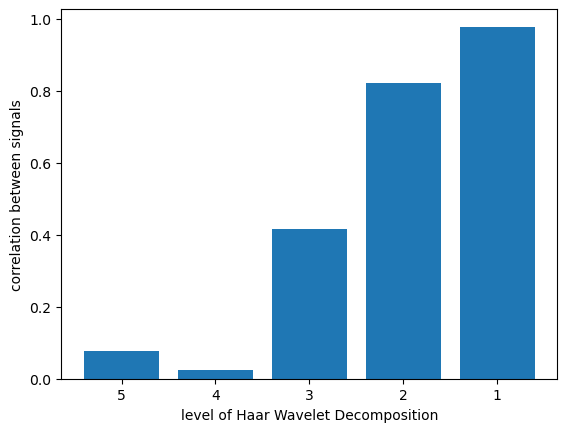

In [85]:
# plot correlation coefficients based on WD level
plt.figure()
plt.bar(range(1,6), corrs)
plt.xlabel('level of Haar Wavelet Decomposition')
plt.ylabel('correlation between signals')
plt.xticks(range(1,6), [5,4,3,2,1])
plt.show()

This result is expected; the finer levels of the wavelet decomposition are highly correlated as these coefficients are picking up mostly the high-frequency noise which is the same for both signals. As the level of decomposition gets coarser, the wavelet coefficients are picking up more of the large-scale signals (the sine and cosine waves) which are uncorrelated, so the correlation coefficient drops. 

Also interesting to note that the lack of correlation in the original signals seems to outweigh the effect of the repeat wavelet convolution which should naturally be introducing correlation at the coarser levels of the decomposition.

In [88]:
# reconstruct the signals using only the first 3 levels (leave out the high-frequency components)

V5 = Wt[0:8, ]
A5 = wd_s[0:8]

W5 = Wt[8:16, ]
D5 = wd_s[8:16]

W4 = Wt[16:32, ]
D4 = wd_s[16:32]

W3 = Wt[32:64, ]
D3 = wd_s[32:64]

avg5 = np.array(A5.T*V5).flatten()
det5 = np.array(D5.T*W5).flatten()
det4 = np.array(D4.T*W4).flatten()
det3 = np.array(D3.T*W3).flatten()

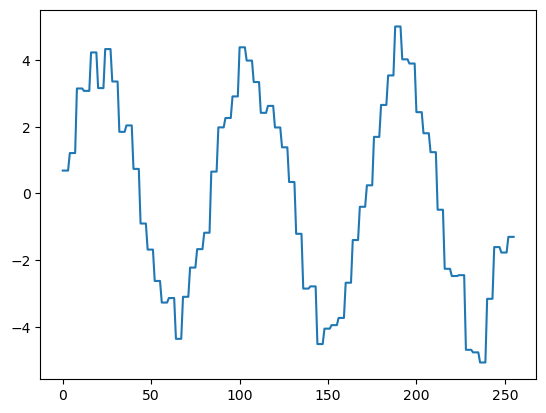

In [89]:
reconstruct_s = avg5 + det5 + det4 + det3 

plt.plot(reconstruct_s)

another (probably more correct) way to do this would be to simply set the wavelet coefficients for levels 2 and 1 to 0, and then perform an inverse DWT to reconstruct the signal.

### Partial Correlation Test

#### 1. Generate partially correlated signals

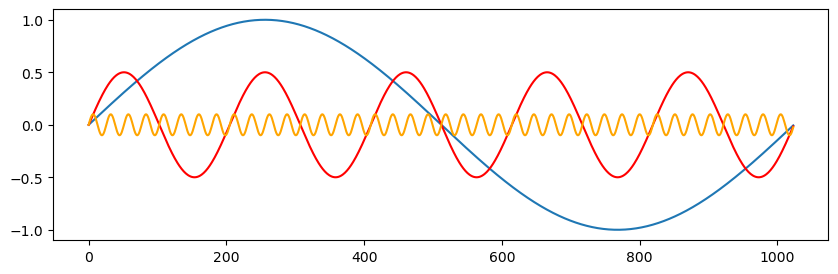

In [5]:
# generate 3 sine waves
resolution = 1024 

sin1 = np.sin(np.arange(0, (2*np.pi), (2*np.pi) / resolution))             # 1  Hz
sin2 = 0.5*np.sin(np.arange(0, (2*np.pi)*5, (2*np.pi)*5 / resolution))     # 5  Hz
sin3 = 0.1*np.sin(np.arange(0, (2*np.pi)*40, (2*np.pi)*40 / resolution))   # 40 Hz


fig = plt.figure(figsize=(10,3))
plt.plot(sin1)
plt.plot(sin2, 'r')
plt.plot(sin3, 'orange')

In [6]:
# use the sine waves to create correlated signals

X1 = sin1 + sin2                                   # this one contains mostly low-freq components
X2 = sin2 + sin3                                   # this one contains mostly high-freq components
Y  = sin1 + sin2 + sin3                            # this one contains low-freq and high-freq components

Text(0.5, 1.0, '$Y$')

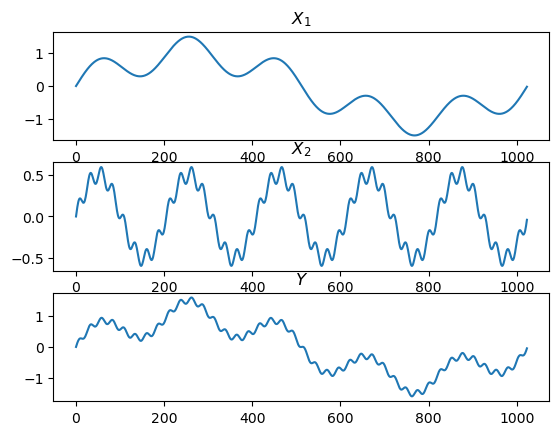

In [8]:
fig, axs = plt.subplots(3,1)

axs[0].plot(X1)
axs[0].set_title('$X_1$')

axs[1].plot(X2)
axs[1].set_title('$X_2$')

axs[2].plot(Y)
axs[2].set_title('$Y$')

Here we let X1 and X2 be combined sine signals; we could also just let X1 be sine1, X2 be sine2, and Y be sine1 + sine2 + sine3 (or even just sine1 + sine2). The partial correlation between Y and X1 will be with the effects of X2 removed from both Y and X1; in this case, the correlation between Y and X1 ignoring mainly the middle frequency. We could also do semi-partial correlation which would remove the effect of X2 from Y only.

Overall, from the partial correlation of Y and X1, we expect the correlation coefficients to be stronger at the coarser levels of decomposition, since we are controlling for the effect of the medium frequency (X2) and X1 lacks the high-frequency component of Y. From the partial correlation of Y and X2, we expect the correlation coefficients to be stronger at the middle levels of the decomposition, since controlling for X1 removes the low-frequency component.

X1 and X2 both share the middle frequency, X1 being the low and middle frequency and X2 being the middle and high frequency. Therefore, the partial correlation of Y and X1, excluding the effect of X2 from both Y and X1, will remove the effect of both the middle and high frequency from Y and the middle frequency from X1. Therefore, all of the correlation should be at the low frequency, and this will be captured by the coarser levels of the wavelet decomposition. 

#### 2. Wavelet Decomposition

Using the Daub-8 wavelet here. Morlet wavelet would be more appropriate though since it is more sinusoidal. 

When we decompose the 3 signals, we expect to see more of the high-frequency fluctuation caused by sin3 captured by the low-level wavelet decomp coefficients while the low-frequency fluctuation caused by sin1 will be captured by the high level (coarse) wavelet decomp coefficients. 

In [10]:
# Symmlet-8 wavelet
hfilt = [-0.07576571478934, -0.02963552764595, 0.49761866763246, 0.80373875180522,
          0.29785779560554, -0.09921954357694, -0.01260396726226, 0.03222310060407]

# arrays should be nx1
X1 = np.transpose(np.matrix(X1))
X2 = np.transpose(np.matrix(X2))
Y = np.transpose(np.matrix(Y))


#use Symmlet-8 wavelet
W = Wavmat(1024, hfilt, 8) 

#WT of data by 'hfilt' @ 8 levels of detail
wd_x1 = W * X1
wd_x2 = W * X2
wd_y = W * Y

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


#### 3. get correlations

In [11]:
dyadic = [4, 8, 16, 32, 64, 128, 256, 512, 1024]

x1_decomps = {}
x2_decomps = {}
y_decomps = {}
for i in range(len(dyadic)-1):
    x1_decomps[f'x1_l{i+1}'] = np.squeeze(np.array(wd_x1[dyadic[i]:dyadic[i+1]]))
    x2_decomps[f'x2_l{i+1}'] = np.squeeze(np.array(wd_x2[dyadic[i]:dyadic[i+1]]))
    y_decomps[f'y_l{i+1}'] = np.squeeze(np.array(wd_y[dyadic[i]:dyadic[i+1]]))
    
x1list = list(x1_decomps.keys())
x2list = list(x2_decomps.keys())
ylist = list(y_decomps.keys())

In [12]:
corrs_y_x1 = []
corrs_y_x2 = []
corrs_x1_x2 = []

for i in range(len(ylist)):
    corrs_y_x1.append(np.corrcoef(y_decomps[ylist[i]], x1_decomps[x1list[i]])[0,1])
    corrs_y_x2.append(np.corrcoef(y_decomps[ylist[i]], x2_decomps[x2list[i]])[0,1])
    corrs_x1_x2.append(np.corrcoef(x1_decomps[x1list[i]], x2_decomps[x2list[i]])[0,1])

#### get partial correlations

In [13]:
# partial correlation of X and Y controlling for Z
def pwc(rxy, rxz, ryz):
    num = rxy - rxz*ryz
    denom = np.sqrt(1-rxz**2)*np.sqrt(1-ryz**2)
    
    return num/denom


pc_y_x1 = []       # partial correlations of Y and X1 controlling for X2
pc_y_x2 = []       # partial correlations of Y and X2 controlling for X1

for i in range(len(corrs_y_x1)):
    pc_y_x1.append(pwc(corrs_y_x1[i], corrs_y_x2[i], corrs_x1_x2[i]))
    pc_y_x2.append(pwc(corrs_y_x2[i], corrs_y_x1[i], corrs_x1_x2[i]))

C:\Users\jgkis\AppData\Local\Temp\ipykernel_17440\1022629636.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  return num/denom


In [14]:
# this is temporary for plotting purposes
pc_y_x2[0] = 0

Text(0.5, 1.0, 'Y and X2')

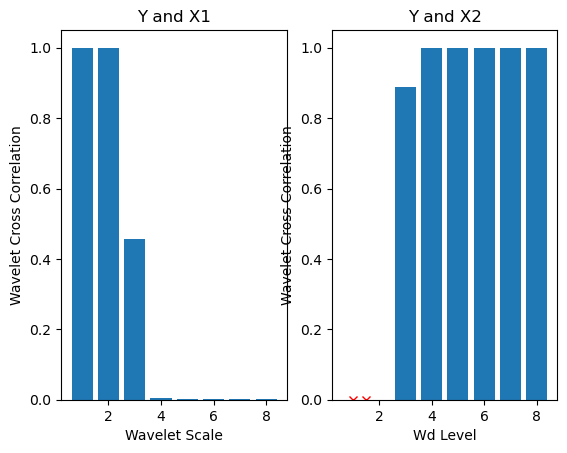

In [15]:
# plot correlation coefficients based on WD level
fig, axs = plt.subplots(1,2)
axs[0].bar(range(1,9), pc_y_x1)
axs[0].set_xlabel('Wavelet Scale')
axs[0].set_ylabel('Wavelet Cross Correlation')
axs[0].set_title('Y and X1')

axs[1].bar(range(1,9), pc_y_x2)
axs[1].plot(1,0, 'rx')
axs[1].plot(1.5, 0, 'rx')
axs[1].set_xlabel('Wd Level')
axs[1].set_ylabel('Wavelet Cross Correlation')
axs[1].set_title('Y and X2')

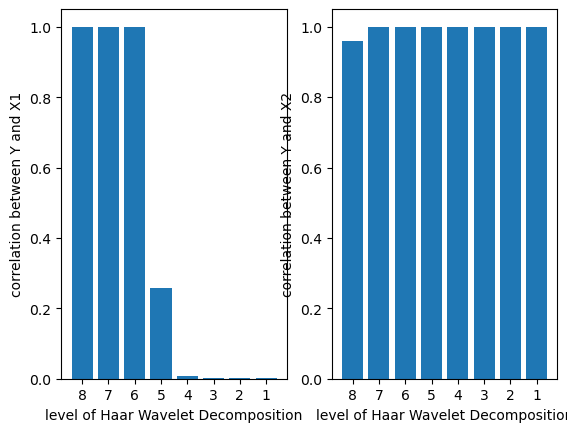

In [127]:
# plot correlation coefficients based on WD level
fig, axs = plt.subplots(1,2)
axs[0,0].plot(range(1,9), corrs_y_x1, 'bo-')
axs[0,0].set_xlabel('Wavelet Scale')
axs[0,0].set_ylabel('Wavelet Cross Correlation')
axs[0,0].set_title('Y and X1')

axs[0,1].plot(range(1,9), corrs_y_x2, 'bo-')
axs[0,1].set_xlabel('Wd Level')
axs[0,1].set_ylabel('Wavelet Cross Correlation')
axs[0,1]

plt.figure()
plt.subplot(1,2,1)
plt.bar(range(1,9), corrs_y_x1)
plt.xlabel('level of Haar Wavelet Decomposition')
plt.ylabel('correlation between Y and X1')
plt.xticks(range(1,9), [8,7,6,5,4,3,2,1])

plt.subplot(1,2,2)
plt.bar(range(1,9), corrs_y_x2)
plt.xlabel('level of Haar Wavelet Decomposition')
plt.ylabel('correlation between Y and X2')
plt.xticks(range(1,9), [8,7,6,5,4,3,2,1])
plt.show()

### Recreation of the WCC paper

In Souza & Felix (2018) the authors explore wavelet cross correlations by generating AR(1) systems of the form $X_t = \alpha X_{t-1} + \epsilon_t$ with $\alpha = 0.8$ and decompose them at 11 levels of detail. They then create 3 correlated systems, $A$ which is a reconstruction of the signal without levels 1, 2, and 3, $B$ which is a reconstruction of the system without levels 5, 6, and 7, and $C$ which is a reconstruction using only levels 1 and 2.

The authors only use cross correlations and lagged cross-correlations, but don't explore partial correlations. However their example would be a good way to visualize the effects of partial correlations.

In [60]:
# generate the AR(1) signal, length 4096
np.random.seed(99)

n = 4096
phi = 0.8

X = np.zeros(n)

for t in range(1,n):
    X[t] = X[t-1]*phi + np.random.standard_normal()

In [61]:
# wavelet decomposition
X = np.transpose(np.matrix(X))

#use default Haar wavelet
Wt = Wavmat(n, None, 9) 

#WT of data by 'hfilt' @ 9 levels of detail
wd_s = Wt * X

# authors use a Daubechies Wavelet

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [63]:
# get the subsignals (in this case I used B without 4, 5, 6)
A = wd_s[56:]
B = wd_s[]

56

### Recreation of PWC paper

in Mihanovic et al. (2009) the authors use continuous wavelet transforms (Morlet Wavelet) to get partial wavelet coherency, which is analagous to partial correlation in the discrete case (I think). They generate 3 signals, 2 of which are mostly noise with seperate pulses of oscillating signals at different times, and a third which is a sum of the other two. They then get the PWC of Y and X1 and Y and X2; because they use continuous wavelet coherency, they are able to generate a grid of correlations which visualizes both the correlation at certain frequency and at certain times.

In [2]:
# first generate two completely uncorrelated signals
np.random.seed(999)

cycles = 3
resolution = 256 

length = np.pi * 2 * cycles
sin = 4*np.sin(np.arange(0, length, length / resolution))
cos = 4*np.cos(np.arange(0, length, length / resolution))

In [19]:
# decompose signals using Haar

# arrays should be nx1
s = np.transpose(np.matrix(sin))
c = np.transpose(np.matrix(cos))


#use default Haar wavelet
Wt = Wavmat(256, None, 5) 

#WT of data by 'hfilt' @ 5 levels of detail
wd_s = Wt * s
wd_c = Wt * c

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [20]:
# get correlation
dyadic = [8, 16, 32, 64, 128, 256]

s_decomps = {}
for i in range(len(dyadic)-1):
    s_decomps[f's_l{i+1}'] = np.squeeze(np.array(wd_s[dyadic[i]:dyadic[i+1]]))

c_decomps = {}
for i in range(len(dyadic)-1):
    c_decomps[f'c_l{i+1}'] = np.squeeze(np.array(wd_c[dyadic[i]:dyadic[i+1]]))
    
Slist = list(s_decomps.keys())
Clist = list(c_decomps.keys())

corrs = []

for i in range(len(Slist)):
    corrs.append(np.corrcoef(s_decomps[Slist[i]], c_decomps[Clist[i]])[0,1])

corrs

[6.071595829906075e-17,
 -8.939652477640226e-17,
 4.2159356640023566e-16,
 1.079558872976213e-16,
 -1.1152969247648713e-16]

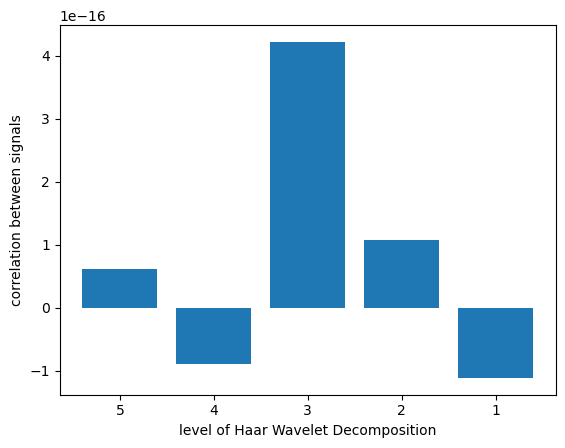

In [21]:
# plot correlation coefficients based on WD level
plt.figure()
plt.bar(range(1,6), corrs)
plt.xlabel('level of Haar Wavelet Decomposition')
plt.ylabel('correlation between signals')
plt.xticks(range(1,6), [5,4,3,2,1])
plt.show()

From the above plot the degree of correlation seems to be pretty minimal at all levels

In [3]:
# function

def wcc(s1, s2, n, l, wavelet=None):
    '''
    This function performs a DWT of two time series and
    then calculates the correlation coefficients between
    the wavelet coefficients at each level. 
    
    Haar wavelet is the default; can be changed with 'wavelet'
    parameter. 'n' is the signal length (must be a power of 2).
    'l' is the level of decomposition
    '''
    
    # arrays should be nx1
    s1 = np.transpose(np.matrix(s1))
    s2 = np.transpose(np.matrix(s2))

    # WT of data @ 'l' levels of detail
    Wt = Wavmat(n, wavelet, l) 

    wd_s1 = Wt * s1
    wd_s2 = Wt * s2
    
    # get correlation
    dyadic = []
    for i in (reversed(range(l+1))):
        dyadic.append(int(n/2**(i)))

    s1_decomps = {}
    s2_decomps = {}
    for i in range(len(dyadic)-1):
        s1_decomps[f's1_l{i+1}'] = np.squeeze(np.array(wd_s1[dyadic[i]:dyadic[i+1]]))
        s2_decomps[f's2_l{i+1}'] = np.squeeze(np.array(wd_s2[dyadic[i]:dyadic[i+1]]))
    
    s1list = list(s1_decomps.keys())
    s2list = list(s2_decomps.keys())

    corrs = []

    for i in range(len(s1list)):
        corrs.append(np.corrcoef(s1_decomps[s1list[i]], s2_decomps[s2list[i]])[0,1])
        
    return corrs

In [48]:
# Monte Carlo
num_simulations = 10
n = 512
l7_corrs = []
l6_corrs = []
l5_corrs = []

for i in range(num_simulations):
    
    # generate white noise signals:
    X1 = np.random.standard_normal((1,n)).flatten()
    X2 = np.random.standard_normal((1,n)).flatten()
    
    corrs = wcc(X1, X2, n, 7)
    
    # keep correlation coefficients for 3 sparsest levels
    l7_corrs.append(corrs[0])
    l6_corrs.append(corrs[1])
    l5_corrs.append(corrs[2])
    

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [51]:
l7_corrs

[0.4873534248277738,
 0.6034259260446124,
 -0.46937567213321585,
 0.2690563267106055,
 -0.26343700014141164,
 0.16742972719367416,
 -0.33767557497430023,
 0.295466169738243,
 0.6258565585615062,
 0.684959351373401]